<a href="https://colab.research.google.com/github/kev1092/Lab3-CV-course-HH/blob/main/lab_3_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2

### Enabling the GPU

First, you'll need to enable GPUs for the notebook:



1.   Navigate to Edit→Notebook Settings
2.   select GPU from the Hardware Accelerator drop-down




# **Computer Vision with Deep Learning and Keras**

We will be building, training, and testing our own Neural Networks (NN) for different computer vision tasks in this lab. However, we will mostly limit ourselves to the case of Object Recognition.

### **Number Recognition with MNIST**

The first task we will analyze is digit recognition, digit and character recognition is one of the oldest problems within computer vision. Our job will be to develop some simple models to help us understand what number is in the image. We will use the MNIST dataset, a well-known digit recognition dataset used as a baseline for benchmarking models.

Let's load our data and check it out.

----------------------------------------------
Shape of the training partition: (60000, 28, 28)
Number of labels in the training partition: (60000,)
----------------------------------------------
Shape of the test partition: (10000, 28, 28)
Number of labels in the test partition: (10000,)
Number of classes in the database is 10, the labels are [0 1 2 3 4 5 6 7 8 9]


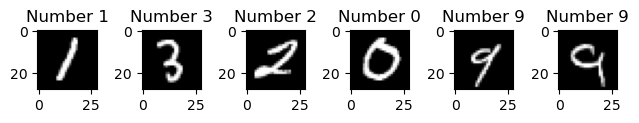

In [ ]:
# we download the data from tensorflow's repositories
# we divide the data en train and test to, as the name suggest, train our models and test them in unseen data
# "x" corresponds to the image data and "y" identify the labels associated with each image
(xtrain, y_train), (xtest, y_test) = keras.datasets.mnist.load_data()

# let's check our data a bit more, first let's see the size and shape of our data
print("----------------------------------------------")
print("Shape of the training partition: {}".format(xtrain.shape))
print("Number of labels in the training partition: {}".format(y_train.shape))
print("----------------------------------------------")
print("Shape of the test partition: {}".format(xtest.shape))
print("Number of labels in the test partition: {}".format(y_test.shape))

# Let's also see how our images look like

for i in range(6):
    plt.subplot(1,6,i+1)
    j = np.random.randint(0, len(xtrain))
    plt.imshow(xtrain[j], cmap='gray')
    plt.title("Number {}".format(y_train[j]))

plt.tight_layout()

print("Number of classes in the database is {}, the labels are {}".format(len(np.unique(y_test)),np.unique(y_test)))

We can see that our training partition has 60k samples of 28x28 pixels and that the test partition has 10k samples of also 28x28 pixels. Furthermore, we can see that we have precisely 1 label per image. This label corresponds with the number in the image, and the database contains the numbers from 0 to 9.



#### **Train a simple NN**

The first idea would be to train a standard Multilayer Perceptron (MLP). Multilayer Perceptron is just a sequence of Fully Connected Layers. These layers are a set of nodes called "neurons" where each of these neurons is connected to all of the inputs to that layer. Each neuron implements the following equation: (image taken from [this blog](https://medium.com/swlh/activation-functions-in-artificial-neural-networks-8aa6a5ddf832), you can check for more information about activation functions)


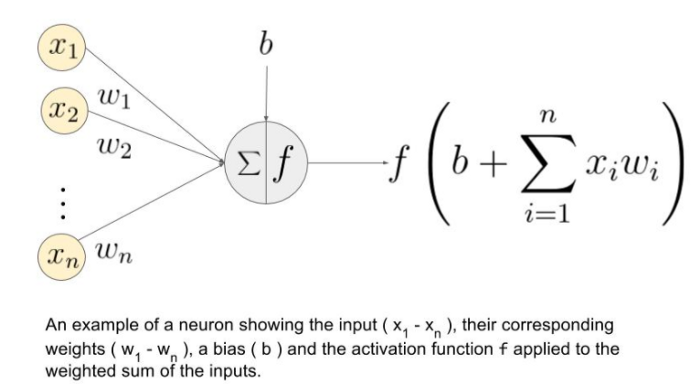

MLPs usually consider of an input layer and output layer and n different "hidden layers" as the following image shows: (image taken from [here](https://laptrinhx.com/future-prospects-of-deep-learning-in-medicine-687217971/))

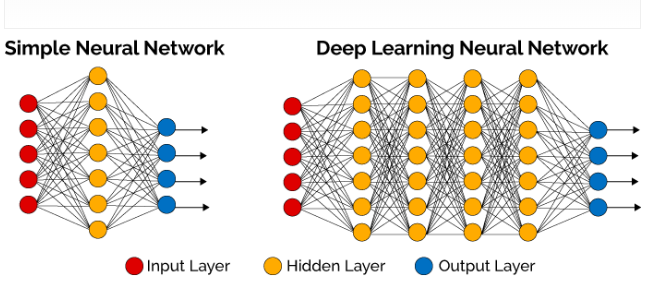

Each neuron usually applies an "activation function" to its output to deal with no linear problems. Where the most commonly used nowadays is ReLU that implements the following formula $output = max(0,x)$.

So now that we have our basic understanding and building blocks let's build our first NN in Keras

In [ ]:
# First, let's normalize our data. This normalization step helps the neural network to be more stable to avoid big weight values and have the same point of reference for all images
# There are many different ways to normalize our data, here we will jsut limit ourself to ensure that the data is between 0 and 1

x_train = xtrain/255
x_test = xtest/255

# usually MLP or fully connected layers expects a one dimensional vector, so we first need to transform our 28x28 pixel images into a vector

x_train_mlp = np.reshape(x_train,(60000,28*28))
x_test_mlp  = np.reshape(x_test,(10000,28*28))

# Let's check that everything is correct

print("Data shape for MLP input: {} with values ranging from {} to {}".format(x_train_mlp.shape,np.min(x_train_mlp),np.max(x_train_mlp)))

Data shape for MLP input: (60000, 784) with values ranging from 0.0 to 1.0


So our data seems to be in the correct format. Let's now build our model! There are mainly 3 ways to build models in Keras (if they are sequential models). We will see them all in this lab.

In [ ]:
# the first way is to create a sequential object and start adding layers to it

model = keras.Sequential()

# we start by adding the input layer
model.add(keras.layers.Input(shape=(28*28,)))

# now we can start adding as many layers as we want, since it is an MLP, we will be using the Dense layer from Keras
# Let's start with a model with only 1 hidden layer with 128 neurons

model.add(keras.layers.Dense(128,activation="ReLU"))

# we have to specify the output of the model.
# Our output will be 10 neurons, each neuron will represent one of the possible numbers that can appear at the input

model.add(keras.layers.Dense(10,activation="Softmax"))


In [ ]:
# Let's print a summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can see that we already have more than 100k parameters with just this little model! But where does this number come from? Let's calculate it

We know that each neuron is connected to all inputs to that layer and that each neuron has 1 bias variable. So, in this case we have #trainable_params = (784 inputs * 128 neurons + 128 bias) + (128 inputs * 10 neurons + 10 bias) which makes 101770 trainable variables

In [ ]:
# Before training, we will shuffle our training data so the validation partition can contain all type of classes
ids = np.arange(0,60000)
np.random.shuffle(ids)
x_train_mlp = x_train_mlp[ids,:]
y_train_mlp = y_train[ids]

# we need to specify which optimizer should we use and what is going to be loss metric
optim = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
model.compile(optimizer=optim,loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# we train our model with our training data in small batches, and we specify a validation partition to control our training process
model.fit(x_train_mlp,y_train_mlp, batch_size=128,epochs=50, validation_split=0.2, shuffle=True)

Epoch 1/50
375/375 [==============================] - 1s 1ms/step - loss: 1.3249 - accuracy: 0.6913 - val_loss: 0.7824 - val_accuracy: 0.8319
Epoch 2/50
375/375 [==============================] - 0s 999us/step - loss: 0.6302 - accuracy: 0.8536 - val_loss: 0.5429 - val_accuracy: 0.8677
Epoch 3/50
375/375 [==============================] - 0s 1ms/step - loss: 0.4859 - accuracy: 0.8766 - val_loss: 0.4607 - val_accuracy: 0.8808
Epoch 4/50
375/375 [==============================] - 0s 998us/step - loss: 0.4237 - accuracy: 0.8876 - val_loss: 0.4182 - val_accuracy: 0.8873
Epoch 5/50
375/375 [==============================] - 0s 1ms/step - loss: 0.3878 - accuracy: 0.8948 - val_loss: 0.3909 - val_accuracy: 0.8926
Epoch 6/50
375/375 [==============================] - 0s 996us/step - loss: 0.3634 - accuracy: 0.9001 - val_loss: 0.3717 - val_accuracy: 0.8975
Epoch 7/50
375/375 [==============================] - 0s 988us/step - loss: 0.3453 - accuracy: 0.9041 - val_loss: 0.3574 - val_accuracy: 0.901

So, there is a lot to unpack here!

First of all, we divided our training data into training and validation. Why do we do that? As its name suggests, the training data is the data that we use during training. However, suppose we use only this data to check the system's performance. In that case, it may be that the model is so powerful that it starts to learn tiny details to improve the recognition performance. Still, it may be that these details are more particularities from the samples and are not reliable for the general case problem. This is what we know as overfitting. To avoid that, we use another partition called validation to check how the changes we make in the network and the training process affect this unseen data partition.

Ok, but if we use this validation partition, why do we need the test partition? It may be that after all our modifications relying on the validation set, we may be overfitting the model based on just that small set of data. Furthermore, we usually decide when to stop the training process based on the validation partition. This includes a bias in our perception of how good the model is. Once we decide on what model and training strategy best fit our purpose, we evaluate the system with the test set and check if the performance on this new unseen data holds.

Now, about the compilation function, we try to optimize our network during the training phase to learn how to recognize our input images and classify them into one of the possible classes. For this, the strategy is first to use a loss function that can tell us how sound the output of our model is with respect to the outcome that we desire it to give. The most common loss function for classification/object recognition is cross-entropy loss. This loss will return a high value if the prediction value for the class that is supposed to be is low. For more information about different loss functions, you can check[this page](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html). Once we have our loss function and our value, we can calculate the gradient of this loss with respect to each of the parameters in our network using the chain rule.

Finally, we need to have a strategy for updating our parameters based on our loss function. This is the role of our optimizer. The optimizer is the strategy for updating each trainable parameter during the training phase. The first optimizer and prevalent approach is to use Stochastic Gradient Descent algorithm. For more information about different optimizers, you can check this [blog](https://www.kdnuggets.com/2020/12/optimization-algorithms-neural-networks.html).



In [ ]:
# Now let's check how our model behaves on the test partition

model.evaluate(x_test_mlp,y_test)

313/313 [==============================] - 0s 421us/step - loss: 0.1680 - accuracy: 0.9494


[0.16801975667476654, 0.949400007724762]

In [ ]:
# we can now save and then load our model with ease!
model.save('MLP_MNIST.h5')

# load back the model to memory
new_model = keras.models.load_model('MLP_MNIST.h5')

/Users/rena/anaconda3/envs/explainableai/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# TO DO: Try to optimize your MLP to improve the results for that try to:
results = []
hidden_layers=1
optimizer_name='SGD'
learning_rate=0.01

# Change the number of neurons in the hidden layer
neurons=256
model = keras.Sequential()
model.add(keras.layers.Input(shape=(28*28,)))
model.add(keras.layers.Dense(neurons, activation="ReLU"))  # Increased neurons from 128 to 256
model.add(keras.layers.Dense(10, activation="Softmax"))

optim = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
model.compile(optimizer=optim, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train_mlp, y_train_mlp, batch_size=128, epochs=50, validation_split=0.2, shuffle=True)
val_accuracy = max(history.history['val_accuracy'])
test_loss, test_accuracy = model.evaluate(x_test_mlp, y_test)
 # Log the results
results.append({
        'neurons': neurons,
        'hidden_layers': hidden_layers,
        'learning_rate': learning_rate,
        'optimizer': optimizer_name,
        'val_accuracy': max(history.history['val_accuracy']),
        'test_accuracy': test_accuracy
    })
# Add more hidden layers
neurons=128
hidden_layers=2
model = keras.Sequential()
model.add(keras.layers.Input(shape=(28*28,)))
model.add(keras.layers.Dense(128, activation="ReLU"))
model.add(keras.layers.Dense(64, activation="ReLU"))  # Added another hidden layer with 64 neurons
model.add(keras.layers.Dense(10, activation="Softmax"))

optim = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
model.compile(optimizer=optim, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train_mlp, y_train_mlp, batch_size=128, epochs=50, validation_split=0.2, shuffle=True)
val_accuracy = max(history.history['val_accuracy'])
test_loss, test_accuracy = model.evaluate(x_test_mlp, y_test)
 # Log the results
results.append({
        'neurons': neurons,
        'hidden_layers': hidden_layers,
        'learning_rate': learning_rate,
        'optimizer': optimizer_name,
        'val_accuracy': max(history.history['val_accuracy']),
        'test_accuracy': test_accuracy
    })

# change the learning rate. How does this affect the training?
hidden_layers=1
learning_rate=0.001
model = keras.Sequential()
model.add(keras.layers.Input(shape=(28*28,)))
model.add(keras.layers.Dense(128, activation="ReLU"))
model.add(keras.layers.Dense(10, activation="Softmax"))

optim = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False)  # Changed learning rate to 0.001
model.compile(optimizer=optim, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train_mlp, y_train_mlp, batch_size=128, epochs=50, validation_split=0.2, shuffle=True)
val_accuracy = max(history.history['val_accuracy'])
test_loss, test_accuracy = model.evaluate(x_test_mlp, y_test)
 # Log the results
results.append({
        'neurons': neurons,
        'hidden_layers': hidden_layers,
        'learning_rate': learning_rate,
        'optimizer': optimizer_name,
        'val_accuracy': max(history.history['val_accuracy']),
        'test_accuracy': test_accuracy
    })

# Change the optimizers, for example use Adam by changing the optim function to optim = keras.optimizers.Adam()
optimizer_name='Adam'
learning_rate=0.01
model = keras.Sequential()
model.add(keras.layers.Input(shape=(28*28,)))
model.add(keras.layers.Dense(128, activation="ReLU"))
model.add(keras.layers.Dense(10, activation="Softmax"))

optim = keras.optimizers.Adam(learning_rate=learning_rate)  # Changed optimizer to Adam
model.compile(optimizer=optim, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train_mlp, y_train_mlp, batch_size=128, epochs=50, validation_split=0.2, shuffle=True)
val_accuracy = max(history.history['val_accuracy'])
test_loss, test_accuracy = model.evaluate(x_test_mlp, y_test)
 # Log the results
results.append({
        'neurons': neurons,
        'hidden_layers': hidden_layers,
        'learning_rate': learning_rate,
        'optimizer': optimizer_name,
        'val_accuracy': max(history.history['val_accuracy']),
        'test_accuracy': test_accuracy
    })
# write a log of the changes that you have tried and the validation accuracy that you achieved

# Print results
for res in results:
    print(f"Neurons: {res['neurons']}, Hidden Layers: {res['hidden_layers']}, Learning Rate: {res['learning_rate']}, "
          f"Optimizer: {res['optimizer']}, Validation Accuracy: {res['val_accuracy']}, Test Accuracy: {res['test_accuracy']}")

# what is the test accuracy for the best model that you got in the previous step? is it similar to the validation accuracy?



Epoch 1/50
375/375 [==============================] - 1s 2ms/step - loss: 1.2274 - accuracy: 0.7195 - val_loss: 0.7238 - val_accuracy: 0.8386
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 0.5891 - accuracy: 0.8584 - val_loss: 0.5168 - val_accuracy: 0.8712
Epoch 3/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4631 - accuracy: 0.8800 - val_loss: 0.4437 - val_accuracy: 0.8811
Epoch 4/50
375/375 [==============================] - 1s 1ms/step - loss: 0.4074 - accuracy: 0.8915 - val_loss: 0.4042 - val_accuracy: 0.8891
Epoch 5/50
375/375 [==============================] - 1s 1ms/step - loss: 0.3740 - accuracy: 0.8989 - val_loss: 0.3798 - val_accuracy: 0.8955
Epoch 6/50
375/375 [==============================] - 1s 2ms/step - loss: 0.3507 - accuracy: 0.9039 - val_loss: 0.3605 - val_accuracy: 0.8991
Epoch 7/50
375/375 [==============================] - 1s 1ms/step - loss: 0.3330 - accuracy: 0.9077 - val_loss: 0.3462 - val_accuracy: 0.9032
Epoch 

Epoch 1/50
375/375 [==============================] - 1s 2ms/step - loss: 1.4114 - accuracy: 0.6352 - val_loss: 0.7650 - val_accuracy: 0.8267
Epoch 2/50
375/375 [==============================] - 0s 1ms/step - loss: 0.5814 - accuracy: 0.8582 - val_loss: 0.4862 - val_accuracy: 0.8725
Epoch 3/50
375/375 [==============================] - 1s 1ms/step - loss: 0.4278 - accuracy: 0.8864 - val_loss: 0.4096 - val_accuracy: 0.8901
Epoch 4/50
375/375 [==============================] - 0s 1ms/step - loss: 0.3717 - accuracy: 0.8981 - val_loss: 0.3723 - val_accuracy: 0.8987
Epoch 5/50
375/375 [==============================] - 1s 1ms/step - loss: 0.3407 - accuracy: 0.9039 - val_loss: 0.3512 - val_accuracy: 0.9025
Epoch 6/50
375/375 [==============================] - 0s 1ms/step - loss: 0.3199 - accuracy: 0.9095 - val_loss: 0.3344 - val_accuracy: 0.9062
Epoch 7/50
375/375 [==============================] - 0s 1ms/step - loss: 0.3037 - accuracy: 0.9132 - val_loss: 0.3213 - val_accuracy: 0.9095
Epoch 

Epoch 1/50
375/375 [==============================] - 1s 1ms/step - loss: 2.1768 - accuracy: 0.2326 - val_loss: 2.0344 - val_accuracy: 0.3951
Epoch 2/50
375/375 [==============================] - 0s 1ms/step - loss: 1.9026 - accuracy: 0.5131 - val_loss: 1.7817 - val_accuracy: 0.5953
Epoch 3/50
375/375 [==============================] - 0s 1ms/step - loss: 1.6593 - accuracy: 0.6531 - val_loss: 1.5501 - val_accuracy: 0.6928
Epoch 4/50
375/375 [==============================] - 0s 1ms/step - loss: 1.4427 - accuracy: 0.7196 - val_loss: 1.3507 - val_accuracy: 0.7402
Epoch 5/50
375/375 [==============================] - 0s 1ms/step - loss: 1.2616 - accuracy: 0.7563 - val_loss: 1.1889 - val_accuracy: 0.7668
Epoch 6/50
375/375 [==============================] - 0s 1ms/step - loss: 1.1170 - accuracy: 0.7809 - val_loss: 1.0613 - val_accuracy: 0.7868
Epoch 7/50
375/375 [==============================] - 0s 1ms/step - loss: 1.0034 - accuracy: 0.7984 - val_loss: 0.9614 - val_accuracy: 0.8006
Epoch 

Epoch 1/50
375/375 [==============================] - 1s 2ms/step - loss: 0.2415 - accuracy: 0.9263 - val_loss: 0.1533 - val_accuracy: 0.9505
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 0.1178 - accuracy: 0.9640 - val_loss: 0.1168 - val_accuracy: 0.9657
Epoch 3/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0896 - accuracy: 0.9718 - val_loss: 0.1279 - val_accuracy: 0.9636
Epoch 4/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0765 - accuracy: 0.9770 - val_loss: 0.1457 - val_accuracy: 0.9614
Epoch 5/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0673 - accuracy: 0.9799 - val_loss: 0.1318 - val_accuracy: 0.9668
Epoch 6/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0663 - accuracy: 0.9801 - val_loss: 0.1361 - val_accuracy: 0.9691
Epoch 7/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0594 - accuracy: 0.9821 - val_loss: 0.1459 - val_accuracy: 0.9682
Epoch 

***ANSWERS***:

Neurons: 256, Hidden Layers: 1, Learning Rate: 0.01, Optimizer: SGD, Validation Accuracy: 0.946, Test Accuracy: 0.9548
Neurons: 128, Hidden Layers: 2, Learning Rate: 0.01, Optimizer: SGD, Validation Accuracy: 0.957, Test Accuracy: 0.9628
Neurons: 128, Hidden Layers: 1, Learning Rate: 0.001, Optimizer: SGD, Validation Accuracy: 0.893, Test Accuracy: 0.9046
Neurons: 128, Hidden Layers: 1, Learning Rate: 0.01, Optimizer: Adam, Validation Accuracy: 0.976, Test Accuracy: 0.9756

The test accuracy and validation accuracy are similar for all tests, including the best model.

The lower learning rate model converged slower, so it didnt reach good accuracy in 50 epochs.**bold text**

#### **Convolutional Neural Networks**

We saw in our previous labs that direct pixel-level comparison for the whole image is not a very good idea, but describing local information and summarizing it can heavily improve recognition performance. Something similar happens when using MLPs and CNNs for image data. There are several advantages to using CNNs over MLPs. The first is that since MLP's neurons are densely connected, as soon as the input image starts to grow and the complexity of the task too, the number of neurons and layers that we need to include would make the number of weights to optimize completely unmanageable. Secondly, it is extremely hard for MLPs to deal with variations in the input data since every single neuron in the first hidden layer will be weighting the information from all pixels in the input image. Even simple variations like shifting the object to be recognized around in the image would yield completely unexpected results (although we can assume that very bad since it was not trained to have that object in that unexpected region). However, we know that a plane is a plane regardless of its position on the image, right?

CNNs are great for computer vision task since it exploits the spatial correlation of features to reduce the number of weights and to help abstract the location of the features to be extracted in the image since, as its name says, in CNNs, we are going to be applying convolutions onto the image. The main advantage of CNNs over handcrafted filters is that they can automatically learn this filter's shape from data.



In [2]:
# Here we have the second way that we can build our sequential model, by simple passing a list of all the layers in it
model = keras.Sequential([keras.layers.Input(shape=(28,28,1)),
                         keras.layers.Conv2D(8,5,padding="same"),
                         keras.layers.ReLU(),
                         keras.layers.MaxPool2D(),
                         keras.layers.Conv2D(16,3,padding="same"),
                         keras.layers.ReLU(),
                         keras.layers.MaxPool2D(),
                         keras.layers.Conv2D(32,3,padding="same"),
                         keras.layers.ReLU(),
                         keras.layers.MaxPool2D(),
                         keras.layers.Flatten(),
                         keras.layers.Dense(10,activation="Softmax")])

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         208       
                                                                 
 re_lu_17 (ReLU)             (None, 28, 28, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 re_lu_18 (ReLU)             (None, 14, 14, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                

We can see that this model has less than 1/10th of the parameters than in the MLP version... but how will it perform?

Before going into the training process, let's first analyze how this parameter number comes to be. We see that the only layers with parameters are the Convolutional and Dense layers (in this simple architecture). We already know how to count the parameters in Dense layers.

let's do each convolutional layer:

first Conv2D: we have 8 filters of size 5x5, so we have 8*5*5 + 8 bias variables (one for each filter) = 208 variables

Second Conv2D: 16 filters * 3x3, so it should be 16*3*3 +16, right? But that gives 160 parameters, and the summary function says that there are 1168 parameters... then why? The thing is that kernel/filters in the Conv2D have one extra dimension, the channel dimension, and this size is the same as the number of channels in the input. So even if we only need to specify the filters to be 3x3, they are actually 3x3x16! So now our numbers should match 1168 = 16*3*3*8 + 16  

Third Conv2D: 32*3*3*16 + 32 = 4640

Dense layer: 288*10+10 = 2890

So now let's train our CNN in a similar way as before.

In [ ]:
x_train_cnn = np.expand_dims(x_train,3)
x_test_cnn = np.expand_dims(x_test,3)
# Before training, we will shuffle our training data so the validation partition can contain all type of classes
ids = np.arange(0,60000)
np.random.shuffle(ids)
x_train_cnn = x_train_cnn[ids,:,:,:]
y_train_cnn = y_train[ids,]

# we need to specify which optimizer should we use and what is going to be loss metric
optim = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
model.compile(optimizer=optim,loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# we train our model with our training data in small batches, and we specify a validation partition to control our training process
model.fit(x_train_cnn,y_train_cnn, batch_size=128,epochs=50, validation_split=0.2, shuffle=True)

Epoch 1/50
375/375 [==============================] - 4s 10ms/step - loss: 2.1648 - accuracy: 0.2949 - val_loss: 1.6341 - val_accuracy: 0.6578
Epoch 2/50
375/375 [==============================] - 4s 9ms/step - loss: 0.6764 - accuracy: 0.8200 - val_loss: 0.3535 - val_accuracy: 0.9037
Epoch 3/50
375/375 [==============================] - 4s 10ms/step - loss: 0.2901 - accuracy: 0.9154 - val_loss: 0.2250 - val_accuracy: 0.9369
Epoch 4/50
375/375 [==============================] - 4s 10ms/step - loss: 0.2081 - accuracy: 0.9384 - val_loss: 0.1875 - val_accuracy: 0.9450
Epoch 5/50
375/375 [==============================] - 4s 10ms/step - loss: 0.1681 - accuracy: 0.9500 - val_loss: 0.1600 - val_accuracy: 0.9495
Epoch 6/50
375/375 [==============================] - 4s 10ms/step - loss: 0.1438 - accuracy: 0.9571 - val_loss: 0.1371 - val_accuracy: 0.9593
Epoch 7/50
375/375 [==============================] - 4s 10ms/step - loss: 0.1262 - accuracy: 0.9620 - val_loss: 0.1234 - val_accuracy: 0.9634


In [ ]:
# Now let's check how our model behaves on the test partition

model.evaluate(x_test_cnn,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0506 - accuracy: 0.9836


[0.05058988183736801, 0.9836000204086304]

In [ ]:
# we can now save and then load our model with ease!
model.save('CNN_MNIST.h5')

# load back the model to memory
new_model = keras.models.load_model('CNN_MNIST.h5')

We can see that even if we have 1/10th of the parameters than in the MLP, we can achieve a much better result! Then... why did I bother you with a whole section about MLP? Well, first, to understand why CNNs are really good for computer vision compared to other neural network architectures, and second because their fully connected architecture is usually a part of CNNs architecture.

CNNs for object recognition can typically be roughly divided into two parts. The first part, the convolutional part, focuses on optimizing the convolutional filters to extract meaningful features from the object in the image. The second part, the fully connected part, focuses on using these extracted features to classify/recognize the object.

In [ ]:
# TO DO:
# Try to optimize the CNN for the MNIST dataset
# ideas: add more convolutional layers, add another fully connected layer before the last Dense layer, change the optimizer to Adam...

model = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(8, 5, padding="same"),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(16, 3, padding="same"),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, 3, padding="same"),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),  # Added another fully connected layer
    keras.layers.Dense(10, activation="softmax")
])

# Prepare data
x_train_cnn = np.expand_dims(x_train, 3)
x_test_cnn = np.expand_dims(x_test, 3)

# Shuffle training data
ids = np.arange(0, x_train_cnn.shape[0])
np.random.shuffle(ids)
x_train_cnn = x_train_cnn[ids, :, :, :]
y_train_cnn = y_train[ids]

# Compile the model with Adam optimizer
optim = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optim, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(x_train_cnn, y_train_cnn, batch_size=128, epochs=50, validation_split=0.2, shuffle=True)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test_cnn, y_test)
print(f'Test accuracy: {test_acc}')

# Save the model
model.save('CNN_MNIST_optimized.h5')

# Load the model back to memory
new_model = keras.models.load_model('CNN_MNIST_optimized.h5')

# keep a log of the changes tried and the validation accuracy
# for the best architecture what is the test accuracy achieved?

Epoch 1/50
375/375 [==============================] - 5s 12ms/step - loss: 0.3532 - accuracy: 0.8985 - val_loss: 0.1206 - val_accuracy: 0.9638
Epoch 2/50
375/375 [==============================] - 4s 12ms/step - loss: 0.0957 - accuracy: 0.9705 - val_loss: 0.0858 - val_accuracy: 0.9729
Epoch 3/50
375/375 [==============================] - 4s 12ms/step - loss: 0.0680 - accuracy: 0.9791 - val_loss: 0.0648 - val_accuracy: 0.9796
Epoch 4/50
375/375 [==============================] - 4s 12ms/step - loss: 0.0552 - accuracy: 0.9830 - val_loss: 0.0501 - val_accuracy: 0.9850
Epoch 5/50
375/375 [==============================] - 4s 12ms/step - loss: 0.0455 - accuracy: 0.9862 - val_loss: 0.0463 - val_accuracy: 0.9860
Epoch 6/50
375/375 [==============================] - 5s 12ms/step - loss: 0.0393 - accuracy: 0.9874 - val_loss: 0.0456 - val_accuracy: 0.9868
Epoch 7/50
375/375 [==============================] - 4s 12ms/step - loss: 0.0329 - accuracy: 0.9899 - val_loss: 0.0479 - val_accuracy: 0.9858

In [ ]:
#With a learning rate 0.01, an additional fully connected layer and Adam optimizer
#test accuracy 0.9799
#valid accuracy 0.9853

model.evaluate(x_test_cnn,y_test)
max(history.history['val_accuracy'])

#changed learning rate to 0.001
#test accuracy 0.9751
#valid accuracy 0.9916

313/313 [==============================] - 1s 2ms/step - loss: 0.1225 - accuracy: 0.9751


0.9915833473205566

Let's try now with other dataset!

We will be using the flower dataset. The dataset is from tensorflow [flower example dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers?hl=es-419) and the next 4 code cells are from [this tutorial](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/image_feature_vector.ipynb#scrollTo=HYQr1SILIxSK).

In [2]:
import os
from six.moves import urllib
import random
import tensorflow.compat.v1 as tf2
import collections
import io
import math

In [4]:
FLOWERS_DIR = './flower_photos'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)


def make_train_and_test_sets():
  """Split the data into train and test sets and get the label classes."""
  train_examples, test_examples = [], []
  shuffler = random.Random(RANDOM_SEED)
  is_root = True
  for (dirname, subdirs, filenames) in tf2.gfile.Walk(FLOWERS_DIR):
    # The root directory gives us the classes
    if is_root:
      subdirs = sorted(subdirs)
      classes = collections.OrderedDict(enumerate(subdirs))
      label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
      is_root = False
    # The sub directories give us the image files for training.
    else:
      filenames.sort()
      shuffler.shuffle(filenames)
      full_filenames = [os.path.join(dirname, f) for f in filenames]
      label = dirname.split('/')[-1]
      label_class = label_to_class[label]
      # An example is the image file and it's label class.
      examples = list(zip(full_filenames, [label_class] * len(filenames)))
      num_train = int(len(filenames) * TRAIN_FRACTION)
      train_examples.extend(examples[:num_train])
      test_examples.extend(examples[num_train:])

  shuffler.shuffle(train_examples)
  shuffler.shuffle(test_examples)
  return train_examples, test_examples, classes

In [5]:
# Download the images and split the images into train and test sets.
download_images()
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))

Flower photos are located in ./flower_photos

The dataset has 5 label classes: odict_values(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
There are 2934 training images
there are 736 test images


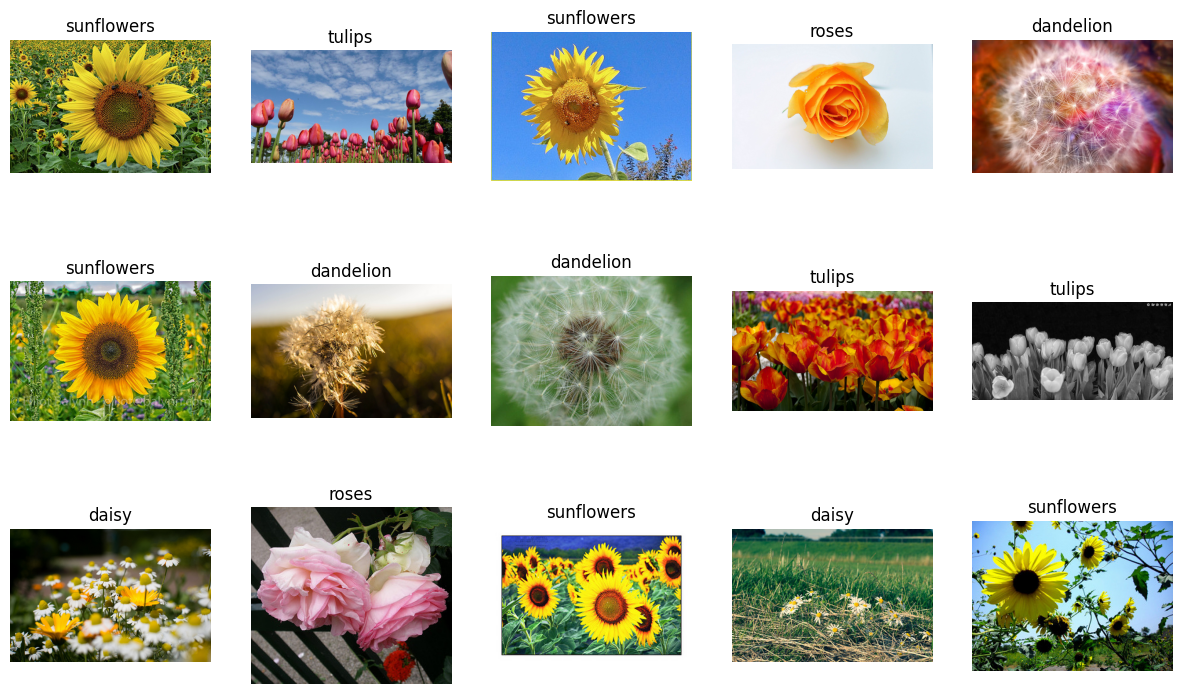

In [6]:
#@title Show some labeled images
def get_label(example):
  """Get the label (number) for given example."""
  return example[1]

def get_class(example):
  """Get the class (string) of given example."""
  return CLASSES[get_label(example)]

def get_encoded_image(example):
  """Get the image data (encoded jpg) of given example."""
  image_path = example[0]
  return tf2.gfile.GFile(image_path, 'rb').read()

def get_image(example):
  """Get image as np.array of pixels for given example."""
  return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
  """Display given images and their labels in a grid."""
  rows = int(math.ceil(len(images_and_classes) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, (image, flower_class) in enumerate(images_and_classes):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(flower_class)

NUM_IMAGES = 15 #@param {type: 'integer'}
display_images([(get_image(example), get_class(example))
               for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

Once we have our dataset, we need to preprocess the images to fit our model. Also, the images are much bigger this time, so it does not fit entirely in RAM. How can we train our model then?

We will divide our training data into training and validation in the following cells. For that, we will create three new folders. Each one will contain only the data for that partition. After creating them, we will copy the images into these separated folders, but before that, we will preprocess them. Our preprocessing step at this time will be very simple. We will limit ourselves to resizing our images to our desired size. Usually, models are built to expect square images, and all have the same size (but this is not a must or some limitation). We will read every image, add the necessary padding to make them square, resize them to our desired size, and finally, save them into the proper folder.

In [7]:


def preprocess_image(img,size):
  top=0
  bottom=0
  left=0
  right=0
  if img.shape[0] > img.shape[1]:
    padd_size = img.shape[0]-img.shape[1]
    top = np.floor(padd_size/2).astype("int")
    bottom = np.ceil(padd_size/2).astype("int")
  elif img.shape[0] < img.shape[1]:
    padd_size = img.shape[1]-img.shape[0]
    left = np.floor(padd_size/2).astype("int")
    right = np.ceil(padd_size/2).astype("int")
  image = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)
  output = cv2.resize(image,(size,size))
  return output

def create_partition_folder(paths,NAME,CLASSES,size):
  os.mkdir(NAME)

  for i in range(5):
    folder = os.path.join("./",NAME,CLASSES[i])
    os.mkdir(folder)

  i=0
  for path,label in paths:
    img = preprocess_image(plt.imread(path),size)
    cv2.imwrite(os.path.join("./",NAME,CLASSES[label],str(i)+".jpg"),img)
    i+=1


ids = np.arange(len(TRAIN_EXAMPLES))
np.random.shuffle(ids)
VAL_EXAMPLES = [TRAIN_EXAMPLES[i] for i in ids[0:(np.floor(len(TRAIN_EXAMPLES)*0.2).astype(int))]]
TRAIN_EXAMPLES2 = [TRAIN_EXAMPLES[i] for i in ids[(np.floor(len(TRAIN_EXAMPLES)*0.2).astype(int)):]]
create_partition_folder(TRAIN_EXAMPLES2,"training",CLASSES,224)
create_partition_folder(VAL_EXAMPLES,"validation",CLASSES,224)
create_partition_folder(TEST_EXAMPLES,"test",CLASSES,224)

This time we will be using the "Functional API" from Keras. This way of model creation is very simple yet very powerful. Contrary to the previous methods, we can create much more complex networks. Our model does not need to be sequential, but we can have branches. This can help us to develop new architectures able to extract more specific features or process the data in particular ways that sequential models may not be able to reach.

In [8]:

# Now we create our model for our data. We will create a simple model using the Functional API from Keras

input = keras.layers.Input(shape=(224,224,3))
x = keras.layers.Conv2D(32,3,padding="same")(input)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Conv2D(64,3,padding="same")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Conv2D(128,3,padding="same")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Conv2D(256,3,padding="same")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Conv2D(512,3,padding="same")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Flatten()(x)
out = keras.layers.Dense(5,activation="Softmax")(x)

model_sequential = keras.Model(input,out)

The previous example is a simple sequential model, similar to the previous ones but with the Functional API. This time, to illustrate the power of no sequential models, we will create a model that implements residual blocks. These "residual blocks" were introduced by [ResNet paper](https://arxiv.org/abs/1512.03385)

In [9]:
input = keras.layers.Input(shape=(224,224,3))
x = keras.layers.Conv2D(32,3,padding="same")(input)
x = keras.layers.ReLU()(x)
x = keras.layers.Conv2D(64,3,padding="same")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D()(x)


_ = keras.layers.Conv2D(64,3,padding="same")(x)
_ = keras.layers.ReLU()(_)
_ = keras.layers.Conv2D(64,3,padding="same")(_)
x = keras.layers.Add()([x,_])
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D()(x)

_ = keras.layers.Conv2D(64,3,padding="same")(x)
_ = keras.layers.ReLU()(_)
_ = keras.layers.Conv2D(64,3,padding="same")(_)
x = keras.layers.Add()([x,_])
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D()(x)

_ = keras.layers.Conv2D(64,3,padding="same")(x)
_ = keras.layers.ReLU()(_)
_ = keras.layers.Conv2D(64,3,padding="same")(_)
x = keras.layers.Add()([x,_])
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D()(x)


#x = keras.layers.Flatten()(x)
x = keras.layers.GlobalAveragePooling2D()(x)
out = keras.layers.Dense(5,activation="Softmax")(x)

model = keras.Model(input,out)

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 224, 224, 32)         896       ['input_3[0][0]']             
                                                                                                  
 re_lu_8 (ReLU)              (None, 224, 224, 32)         0         ['conv2d_8[0][0]']            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 224, 224, 64)         18496     ['re_lu_8[0][0]']             
                                                                                            

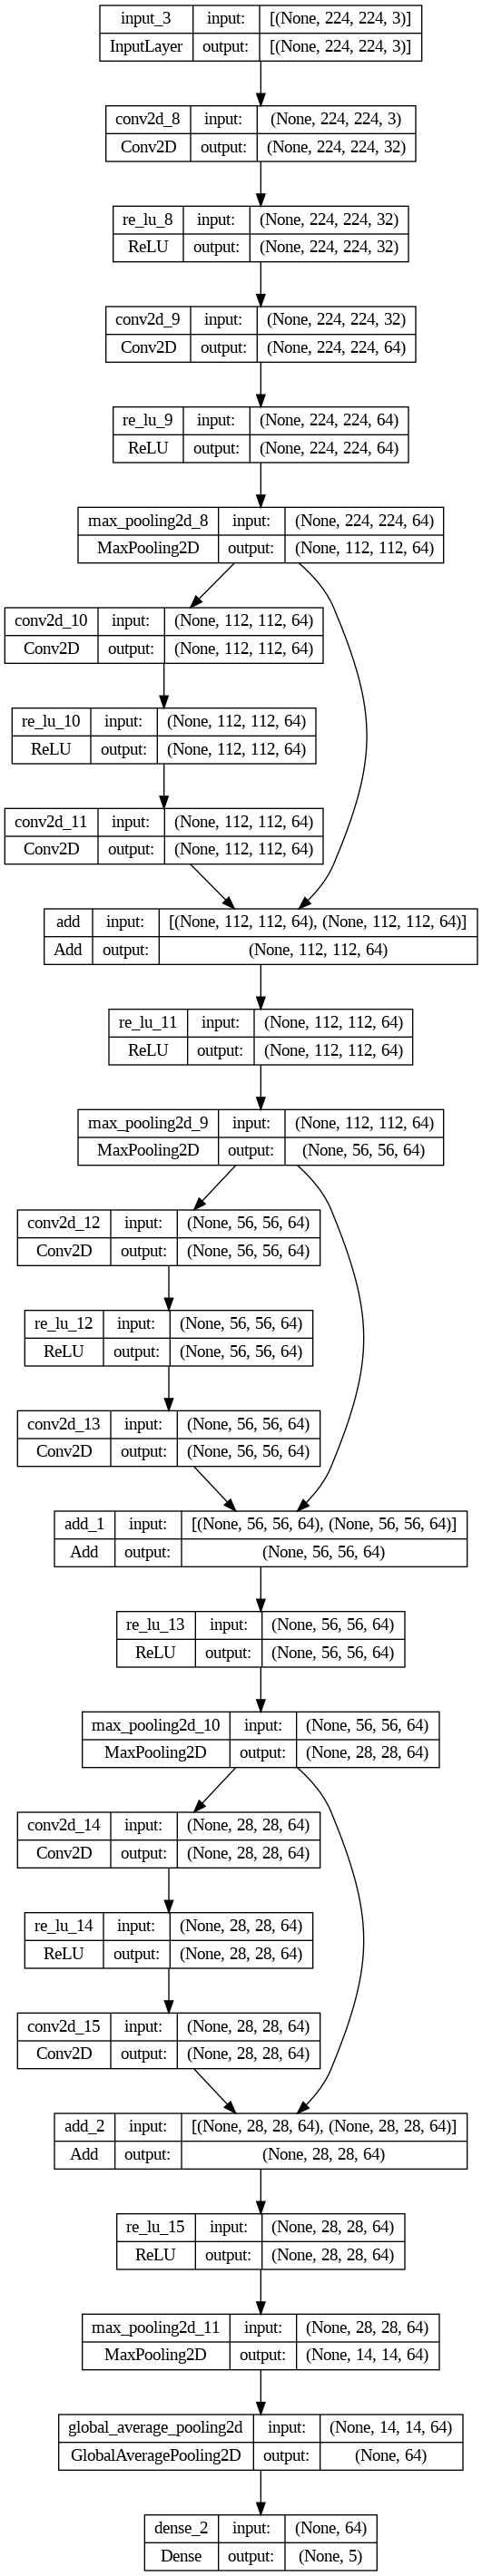

In [11]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_functional.png')

Image(filename='model_functional.png')

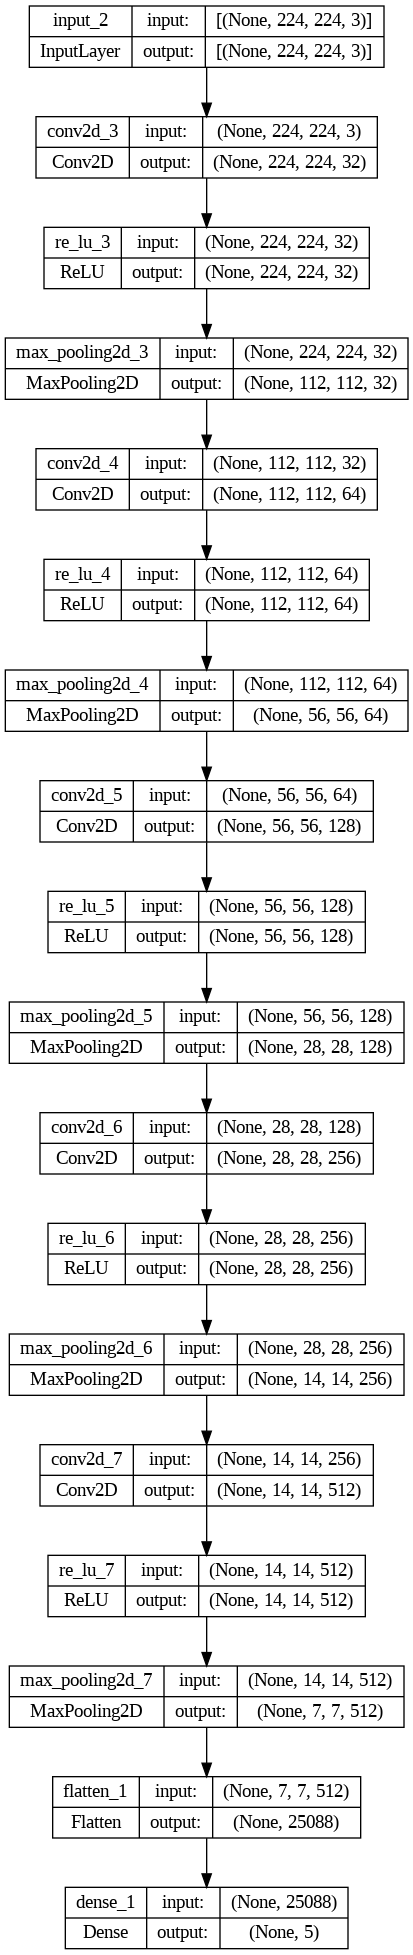

In [12]:
plot_model(model_sequential, show_shapes=True, show_layer_names=True, to_file='model_sequential.png')
Image(filename='model_sequential.png')

You can see above the graphs representing the two model architectures created with the functional API. In our mini resnet model, you can see the no-sequential architecture of the residual blocks



In [13]:
generator_training = keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True, #normalization step in the input for more stable training and prediction
    samplewise_std_normalization=True, #normalization step in the input for more stable training and prediction
    rotation_range=0,
    zoom_range=0.0, #these 4 variables are used for data augmentation, they usually help to give better results. Although here they are "off"
    horizontal_flip=False,
    vertical_flip=False
)

generator_test = keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True, #normalization step in the input for more stable training and prediction
    samplewise_std_normalization=True, #normalization step in the input for more stable training and prediction
    rotation_range=0,
    zoom_range=0.0,
    horizontal_flip=False,
    vertical_flip=False
)

# we need to specify which optimizer should we use and what is going to be loss metric
optim = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
model.compile(optimizer=optim,loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# we train our model with our training data in small batches, and we specify a validation partition to control our training process
model.fit(generator_training.flow_from_directory("./training/",class_mode="sparse",batch_size=32,target_size=(224,224)),
          validation_data=generator_test.flow_from_directory("./validation/",class_mode="sparse",batch_size=32,target_size=(224,224)),
          epochs=50)

Found 2348 images belonging to 5 classes.
Found 586 images belonging to 5 classes.
Epoch 1/50
74/74 [==============================] - 25s 218ms/step - loss: 1.4957 - accuracy: 0.3382 - val_loss: 1.3643 - val_accuracy: 0.3413
Epoch 2/50
74/74 [==============================] - 12s 160ms/step - loss: 1.2859 - accuracy: 0.4216 - val_loss: 1.1994 - val_accuracy: 0.4334
Epoch 3/50
74/74 [==============================] - 12s 161ms/step - loss: 1.2170 - accuracy: 0.4519 - val_loss: 1.1742 - val_accuracy: 0.5017
Epoch 4/50
74/74 [==============================] - 12s 164ms/step - loss: 1.1958 - accuracy: 0.4825 - val_loss: 1.1154 - val_accuracy: 0.5154
Epoch 5/50
74/74 [==============================] - 12s 167ms/step - loss: 1.1738 - accuracy: 0.4974 - val_loss: 1.0864 - val_accuracy: 0.5341
Epoch 6/50
74/74 [==============================] - 13s 169ms/step - loss: 1.1570 - accuracy: 0.5038 - val_loss: 1.1402 - val_accuracy: 0.4283
Epoch 7/50
74/74 [==============================] - 13s 169

In [14]:
model.evaluate(generator_test.flow_from_directory("./test/",class_mode="sparse",target_size=(224,224)))

Found 736 images belonging to 5 classes.
23/23 [==============================] - 2s 69ms/step - loss: 0.7465 - accuracy: 0.7351


[0.7465276122093201, 0.7350543737411499]

In [15]:
model.save('my_resnet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# TO DO:
# play around with the generator_training parameters, number of filters, number of residual blocks, layers, and epochs! tot ry to optimize the results

# Define the data generators with more complex augmentation parameters
generator_training = keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=30,   # Increased rotation range
    zoom_range=0.2,      # Increased zoom range
    horizontal_flip=True,
    vertical_flip=False,
    width_shift_range=0.1,  # Added width shift
    height_shift_range=0.1  # Added height shift
)

generator_test = keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)

# more complex model architecture with batch normalization and an additional dense layer
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(64, 3, padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(128, 3, padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(256, 3, padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128, activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model with the Adam optimizer
optim = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optim, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    generator_training.flow_from_directory("./training/", class_mode="sparse", batch_size=32, target_size=(224, 224)),
    validation_data=generator_test.flow_from_directory("./validation/", class_mode="sparse", batch_size=32, target_size=(224, 224)),
    epochs=50,

)

# Evaluate the model
test_loss, test_acc = model.evaluate(generator_test.flow_from_directory("./test/", class_mode="sparse", target_size=(224, 224)))
print(f'Test accuracy: {test_acc}')

# Save the model
model.save('optimized_model_v3.h5')

# Optional: Log changes and validation accuracy
log = {
    "architecture": "Conv2D(32, 3) -> BatchNorm -> ReLU -> MaxPool2D -> Conv2D(64, 3) -> BatchNorm -> ReLU -> MaxPool2D -> Conv2D(128, 3) -> BatchNorm -> ReLU -> MaxPool2D -> Conv2D(256, 3) -> BatchNorm -> ReLU -> MaxPool2D -> Flatten -> Dense(512) -> BatchNorm -> ReLU -> Dropout(0.5) -> Dense(128) -> BatchNorm -> ReLU -> Dropout(0.5) -> Dense(10, softmax)",
    "optimizer": "Adam",
    "learning_rate": "scheduler",
    "batch_size": 32,
    "epochs": 50,
    "validation_accuracy": max(history.history['val_accuracy']),
    "test_accuracy": test_acc
}

print(log)

Found 2348 images belonging to 5 classes.
Found 586 images belonging to 5 classes.
Epoch 1/50
74/74 [==============================] - 38s 435ms/step - loss: 1.7267 - accuracy: 0.4114 - val_loss: 1.5708 - val_accuracy: 0.4044
Epoch 2/50
74/74 [==============================] - 31s 417ms/step - loss: 1.2577 - accuracy: 0.5183 - val_loss: 1.4821 - val_accuracy: 0.4352
Epoch 3/50
74/74 [==============================] - 31s 422ms/step - loss: 1.1411 - accuracy: 0.5588 - val_loss: 1.0905 - val_accuracy: 0.5410
Epoch 4/50
74/74 [==============================] - 33s 441ms/step - loss: 1.0640 - accuracy: 0.5886 - val_loss: 1.5659 - val_accuracy: 0.4283
Epoch 5/50
74/74 [==============================] - 31s 416ms/step - loss: 0.9988 - accuracy: 0.6265 - val_loss: 1.9651 - val_accuracy: 0.3805
Epoch 6/50
74/74 [==============================] - 32s 433ms/step - loss: 0.9388 - accuracy: 0.6474 - val_loss: 0.9444 - val_accuracy: 0.6365
Epoch 7/50
74/74 [==============================] - 31s 413

Test accuracy: 0.6820651888847351
{'architecture': 'Conv2D(32, 3) -> ReLU -> MaxPool2D -> Conv2D(64, 3) -> ReLU -> MaxPool2D -> Conv2D(128, 3) -> ReLU -> MaxPool2D -> Flatten -> Dense(256, relu) -> Dense(10, softmax)', 'optimizer': 'Adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'validation_accuracy': 0.73549485206604, 'test_accuracy': 0.6820651888847351}

Test accuracy: 0.7554348111152649
{'architecture': 'Conv2D(32, 3) -> ReLU -> MaxPool2D -> Dropout(0.25) -> Conv2D(64, 3) -> ReLU -> MaxPool2D -> Dropout(0.25) -> Conv2D(128, 3) -> ReLU -> MaxPool2D -> Dropout(0.25) -> Conv2D(256, 3) -> ReLU -> MaxPool2D -> Flatten -> Dense(512, relu) -> Dropout(0.5) -> Dense(10, softmax)', 'optimizer': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'validation_accuracy': 0.7986348271369934, 'test_accuracy': 0.7554348111152649}

Test accuracy: 0.7635869383811951
{'architecture': 'Conv2D(32, 3) -> BatchNorm -> ReLU -> MaxPool2D -> Conv2D(64, 3) -> BatchNorm -> ReLU -> MaxPool2D -> Conv2D(128, 3) -> BatchNorm -> ReLU -> MaxPool2D -> Conv2D(256, 3) -> BatchNorm -> ReLU -> MaxPool2D -> Flatten -> Dense(512) -> BatchNorm -> ReLU -> Dropout(0.5) -> Dense(128) -> BatchNorm -> ReLU -> Dropout(0.5) -> Dense(10, softmax)', 'optimizer': 'Adam', 'learning_rate': 'scheduler', 'batch_size': 32, 'epochs': 50, 'validation_accuracy': 0.8208191394805908, 'test_accuracy': 0.7635869383811951}

#### **Transfer Learning and useful functions!**

Finally, in this section, we will see ways to do transfer learning and show some useful functions to improve your training experience!

Transfer Learning refers to using a model that was already trained with another dataset and fine-tuning it to the task you want. The idea here is that a fully trained network for massive datasets will have filters able to extract beneficial information for recognizing many different types of objects in different scenarios, thus getting a good headstart for your task, reducing the amount of training necessary, and usually working better, especially when the amount of data is limited.

In [3]:
# Let's download the resnet model available in keras
model = keras.applications.ResNet50(include_top=True, weights="imagenet",input_shape=(224,224,3))

# this model is a trained resnet50 model trained with the imagenet dataset, let's take a look at the model architecture
model.summary()
print("the model has {} layers".format(len(model.layers)))

102967424/102967424 [==============================] - 246s 2us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                  

We can see that this model has 177 layers and more than 25 million parameters to train. However, this is not a very good way to inspect how the architecture looks like. Take a look at the graphical representation of the network's architecture.

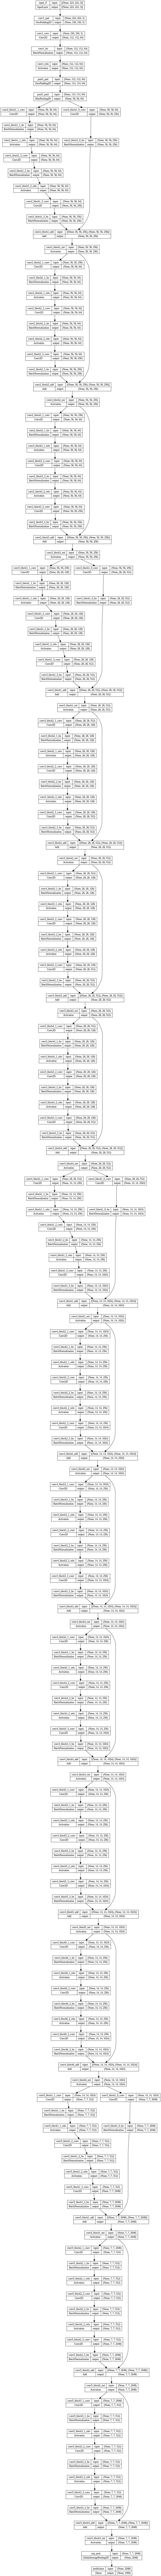

In [22]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_resnet.png')
Image(filename='model_resnet.png')

One new layer that we can see is the "BatchNormalization Layer" this layer is used to stabilize the performance and training of the network by normalizing the data.

We can also see that the last layer is the classification layer used for the Imagenet dataset with 1000 neurons, one for each class. However, our dataset only has 5 classes. To train our network, one discards the fully connected part and creates a new one with the desired shape and number of neurons. This could be easily done when we created the model by setting the "include_top" to False and setting the parameter "classes" to 5. But let's see how one would typically do it with any model.

We saw that thanks to the Functional API from Keras, we can create a model by giving the function Model the input and output of the desired model. However, this input and output need to be connected in a graph, as we did when creating our model with the functional API before. We did it by passing at the creation of a new layer what is its input which is a reference to another layer object.

In [4]:
# first we create our new Dense layer and connect it to the desired layer in the original model
out = keras.layers.Dense(5,activation="Softmax")(model.layers[-2].output)

# now we create our new model
model2 = keras.Model(model.input,out)

# let's check our new model
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

Now we see that our model has the correct shape, so we can start training with our dataset! But before that, it is worth mentioning that one possible use for pretrained CNNs is to use them directly as feature extractors for images. We can do this by removing just the last layer of the network. This way, when we feed an image, we get a vector of features that we can use in the same way we would use HOG or LBPH vectors.

See the example below.

In [5]:
# we basically do the same as before
feature_extractor = keras.Model(model.input,model.layers[-2].output)

# let's try this with an image
img = cv2.resize(plt.imread("./flower_photos/daisy/100080576_f52e8ee070_n.jpg"),(224,224))

# Now we need to use the same preprocessing steps as the original model used and predict with the model
# we will just keep it simple for this example of use and directly resize our image without caring about possible distortion due to the resize

pred = feature_extractor.predict(keras.applications.resnet50.preprocess_input(np.expand_dims(img,0)))

# Now let's check the vector!
print(pred)
print("the vector is of length {}".format(len(pred[0])))

# we can see that the vector is of the expected size from the model summary from above
# now we can use our feaature vector for our new task
# This method is usually known as zero-shot learning

1/1 [==============================] - 0s 423ms/step
[[5.9774594  0.07044114 0.6419711  ... 0.35792175 0.         0.50617355]]
the vector is of length 2048


Finally, before training our model, we will see a new set of functions that are extremely useful when training DL models. These functions are called callbacks functions. Callbacks are functions that are executed at running time when training, predicting, or evaluating a model. They allow us to apply specific actions that are very helpful! Here, we will see two of the most used ones, ModelCheckpoint and EarlyStopping. For a complete list of available callbacks and tutorials on how to write your own, please visit their documentation page [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).

ModelCheckpoint allows us to save the best model found during training. From the previous examples, you saw how the validation accuracy changes from epoch to epoch. In some cases, it gets worse. Furthermore, suppose we train our network for very long. In that case, we have the risk of overfitting our model or stopping at not an optimal point. Because of this, we usually monitor the validation set.

EarlyStopping allows us to stop the training process when certain conditions are met. It helps us "remove" the epoch hyperparameter. We can now set a very big epoch count without worrying. Still, if we see that the model stops improving after a certain point, this callback function stops the training process by itself. Again, as before, we usually monitor the validation set.

These two functions are usually used together to retrieve the best model after stopping.

You can see an example below. But before that, we need to apply some modifications to the generator used before. Since we use a pretrained model, we need to preprocess our input to the normalization done when the model was trained. For this, we can add this preprocessing function to our generators.

In [10]:
generator_training = keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=False, # we remove this two options since the normalization is done by the preprocessing function
    samplewise_std_normalization=False, # we remove this two options since the normalization is done by the preprocessing function
    rotation_range=0,
    zoom_range=0.0,
    horizontal_flip=False, # change these parameter to True or some value to do data augmentation
    vertical_flip=False,
    preprocessing_function=keras.applications.resnet50.preprocess_input # new parameter!
)

generator_test = keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=False, #same as before
    samplewise_std_normalization=False, #same as before
    rotation_range=0,
    zoom_range=0.0,
    horizontal_flip=False,#remember to keep these values to False/0 for testing/validation!
    vertical_flip=False,
    preprocessing_function=keras.applications.resnet50.preprocess_input # new parameter!
)

# we need to specify which optimizer should we use and what is going to be loss metric
optim = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
model.compile(optimizer=optim,loss="sparse_categorical_crossentropy", metrics=["accuracy"])


# Here we configure our callback functions
callback = [tf.keras.callbacks.EarlyStopping(
              monitor='val_loss', # variable to monitor
              patience=5, # how many epochs to wait before stopping
              restore_best_weights=False), # if retrieve the best model achieved, if set to true it would be the same as using the ModelCheckpoint callback when monitor the same variable
            tf.keras.callbacks.ModelCheckpoint(
                filepath="./best_trained_model.h5", # filepath in which save the file
                save_weights_only=False, # to just save the weights instead of the whole model
                monitor='val_accuracy', # variable to monitor (it is a common practice to better monitor the loss instead of accuracy, this is just an example)
                mode='max', # check the minimum or maximum value for the variable to monitor
                save_best_only=True)] #if only to save the best or more

# we train our model with our training data in small batches, and we specify a validation partition to control our training process
model.fit(generator_training.flow_from_directory("./training/",class_mode="sparse",batch_size=32,target_size=(224,224)),
          validation_data=generator_test.flow_from_directory("./validation/",class_mode="sparse",batch_size=32,target_size=(224,224)),
          epochs=7,
          callbacks=callback)

#in order to load our model back we do as before

model_fine_tuned = keras.models.load_model('best_trained_model.h5')

Found 2348 images belonging to 5 classes.
Found 586 images belonging to 5 classes.
Epoch 1/7
74/74 [==============================] - 197s 3s/step - loss: 0.0057 - accuracy: 0.9991 - val_loss: 0.2763 - val_accuracy: 0.9181
Epoch 2/7
74/74 [==============================] - 194s 3s/step - loss: 0.0054 - accuracy: 0.9996 - val_loss: 0.2969 - val_accuracy: 0.9078
Epoch 3/7
74/74 [==============================] - 194s 3s/step - loss: 0.0037 - accuracy: 0.9996 - val_loss: 0.2774 - val_accuracy: 0.9198
Epoch 4/7
74/74 [==============================] - 194s 3s/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.2875 - val_accuracy: 0.9181
Epoch 5/7
74/74 [==============================] - 193s 3s/step - loss: 0.0055 - accuracy: 0.9991 - val_loss: 0.2840 - val_accuracy: 0.9215
Epoch 6/7
74/74 [==============================] - 195s 3s/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.2728 - val_accuracy: 0.9164
Epoch 7/7
74/74 [==============================] - 194s 3s/step - loss: 0.002

Finally, some special modification that is useful to take into account during transfer learning is to freeze at least part of the model or change the learning rate of the trained layers to avoid destroying helpful information!
Below is an example of how to freeze the model

In [11]:
model.trainable = False  # Freeze the model as a whole (must be done before putting the new fully connected layers otherwise the model will not be able to train!)

# we can also just froze particular layers of the model
model.layers[0].trainable = False  # `trainable` can be propagated recursively

# we can use the latter in a loop to freeze only parts of the model or just use a frozen model as a "layer" before calling the keras.Model() function


In [ ]:
# TO DO:
# finetune the resnet50 model with and without transfer learning, try to optimize the training (just a bit, for fun) to achieve better results
# evaluate both models on the test partitions and report the values
# comment on what benefit, if any, gives you doing transfer learning

# in order to create a resnet50 model from scratch (without any kind of pretraining) just change the parameter in the creation functions to "weights=None"
# now you can change the preprocessing function if you want

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the data generators
generator_training = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

generator_test = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_data = generator_training.flow_from_directory(
    "./training/",
    class_mode="sparse",
    batch_size=32,
    target_size=(224, 224)
)

val_data = generator_test.flow_from_directory(
    "./validation/",
    class_mode="sparse",
    batch_size=32,
    target_size=(224, 224)
)

# Load the pre-trained ResNet50 model with ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optim, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath="best_trained_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')
]

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)

# Evaluate the model on the test set
test_data = generator_test.flow_from_directory(
    "./test/",
    class_mode="sparse",
    target_size=(224, 224)
)

test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy with transfer learning: {test_acc}')


Found 2348 images belonging to 5 classes.
Found 586 images belonging to 5 classes.
94765736/94765736 [==============================] - 28s 0us/step


Epoch 1/20
74/74 [==============================] - 68s 897ms/step - loss: 15.1490 - accuracy: 0.6525 - val_loss: 1.2411 - val_accuracy: 0.7833
Epoch 2/20
74/74 [==============================] - 68s 919ms/step - loss: 1.0139 - accuracy: 0.7428 - val_loss: 0.5628 - val_accuracy: 0.8345
Epoch 3/20
74/74 [==============================] - 66s 894ms/step - loss: 0.8226 - accuracy: 0.7551 - val_loss: 0.7777 - val_accuracy: 0.8089
Epoch 4/20
74/74 [==============================] - 65s 884ms/step - loss: 0.7605 - accuracy: 0.7713 - val_loss: 0.4964 - val_accuracy: 0.8464
Epoch 5/20
74/74 [==============================] - 66s 887ms/step - loss: 0.7300 - accuracy: 0.7798 - val_loss: 0.5462 - val_accuracy: 0.8481
Epoch 6/20
74/74 [==============================] - 66s 889ms/step - loss: 0.6411 - accuracy: 0.7934 - val_loss: 0.5448 - val_accuracy: 0.8584
Epoch 7/20
74/74 [==============================] - 66s 891ms/step - loss: 0.5926 - accuracy: 0.8156 - val_loss: 0.4938 - val_accuracy: 0.868

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generators
generator_training = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

generator_test = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_data = generator_training.flow_from_directory(
    "./training/",
    class_mode="sparse",
    batch_size=32,
    target_size=(224, 224)
)

val_data = generator_test.flow_from_directory(
    "./validation/",
    class_mode="sparse",
    batch_size=32,
    target_size=(224, 224)
)

# Load the ResNet50 model without pre-trained weights
base_model_scratch = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x_scratch = Flatten()(base_model_scratch.output)
x_scratch = Dense(512, activation='relu')(x_scratch)
x_scratch = Dropout(0.5)(x_scratch)
x_scratch = Dense(10, activation='softmax')(x_scratch)

# Define the model
model_scratch = Model(inputs=base_model_scratch.input, outputs=x_scratch)

# Compile the model with the legacy Adam optimizer
optim_legacy = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model_scratch.compile(optimizer=optim_legacy, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath="best_trained_model_scratch.h5", save_best_only=True, monitor='val_accuracy', mode='max')
]

# Train the model from scratch
history_scratch = model_scratch.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)

# Evaluate the model on the test set
test_data = generator_test.flow_from_directory(
    "./test/",
    class_mode="sparse",
    target_size=(224, 224)
)

test_loss_scratch, test_acc_scratch = model_scratch.evaluate(test_data)

print(f'Test accuracy from scratch: {test_acc_scratch}')


Found 2348 images belonging to 5 classes.
Found 586 images belonging to 5 classes.
Epoch 1/20
74/74 [==============================] - 228s 3s/step - loss: 34.2353 - accuracy: 0.2108 - val_loss: 2.3834 - val_accuracy: 0.2304
Epoch 2/20
74/74 [==============================] - 229s 3s/step - loss: 6.9929 - accuracy: 0.2036 - val_loss: 1.7221 - val_accuracy: 0.2253
Epoch 3/20
74/74 [==============================] - 217s 3s/step - loss: 1.7833 - accuracy: 0.2423 - val_loss: 1.5959 - val_accuracy: 0.2713
Epoch 4/20
74/74 [==============================] - 222s 3s/step - loss: 1.5462 - accuracy: 0.3143 - val_loss: 1.4933 - val_accuracy: 0.3294
Epoch 5/20
74/74 [==============================] - 227s 3s/step - loss: 1.4678 - accuracy: 0.3637 - val_loss: 1.3782 - val_accuracy: 0.3549
Epoch 6/20
74/74 [==============================] - 231s 3s/step - loss: 1.4496 - accuracy: 0.3663 - val_loss: 1.3187 - val_accuracy: 0.4198
Epoch 7/20
74/74 [==============================] - 225s 3s/step - los

In [19]:
print(f'Test accuracy with transfer learning: {test_acc}')
print(f'Test accuracy from scratch: {test_acc_scratch}')


Test accuracy with transfer learning: 0.8491848111152649
Test accuracy from scratch: 0.551630437374115


Transfer learning resulted in better accuracy since the model leverages pre-trained weights from a large dataset (e.g., ImageNet).
Training converges faster since the model starts with weights that have already been optimized for general features.
Finally, pre-trained models are often better at generalizing to new data, reducing the risk of overfitting, especially with smaller datasets.